# Perth OpenStreetMap data wrangling

The goal of this project is to choose an area of the world in https://www.openstreetmap.org, assess the quality of data for validity, accuracy, completeness, consistency and uniformity, clean it, and import to MongoDB.

Following steps were performed:

1. Defining functions to clean problematic tags, street names and types, maximum speed values, and cycling-related tags.
2. Transformation of data to Python dictionary and export to JSON format.
3. Connecting to MongoDB and importing data.
4. Data exploration of database in MongoDB using queries requested from Python.


A custom Perth area was selected and downloaded as OSM XML from Mapzen to perform the exercise. The file structure is described in the relevant openstreetmap wiki:
https://wiki.openstreetmap.org/wiki/OSM_XML

File is downloaded from https://mapzen.com/data/metro-extracts/metro/perth_australia/
perth_australia.osm.bz2   Zipped OSM XML file, unzipped after that (perth_australia.osm)


## 1. Auditing Data

Firtly, I will open the file and analyse how many different element types are in there.
Parsing with ElementTree should be used because the dataset is too large for processing in memory.



In [43]:
#   https://docs.python.org/2/library/xml.etree.elementtree.html
import xml.etree.cElementTree as ET
#will need it latter for defining wrong names
from collections import defaultdict
#  https://docs.python.org/3/library/re.html
#regular expression module
import re
import pprint

filename='perth_australia.osm'

tags = {}
#parsing XML file to get a list of tags in dataset
#iterparse
#Parses an XML section into an element tree incrementally, and reports what’s going on to the user.
for event, elem in ET.iterparse(filename):  
    if elem.tag in tags: 
        tags[elem.tag] += 1
    else:                
        tags[elem.tag] = 1

pprint.pprint(tags)


{'bounds': 1,
 'member': 14722,
 'nd': 1472543,
 'node': 1203891,
 'osm': 1,
 'relation': 2066,
 'tag': 395261,
 'way': 145666}


Example of elements:
bounds:1
member: 14722
nd  1472543 contains mostly references
node 1203891 latitude("lat"), longitude("lon"), version, timestamp, changeset,user...etc
osm 1
relation
tag 395261 contains information on aeroway,length, ref, surface,width 
way 145666 contains information on id, version, timestamp, etc...

Only 2 types of top level tags are processed: "node" and "way". Others are dropped.
There are 1203891 nodes and 395261 tags which I will have to analyse.


More on tags:
Examle: <tag k="natural" v="wood"/>

- all attributes of "node" and "way" are turned into regular key/value pairs, except:
    - attributes in the CREATED array are dded under a key "created"
    - attributes for latitude and longitude are added to a "pos" array, where
      the values are floats

- if second level tag "k" value starts with "addr:", it is added to a dictionary "address"
- if second level tag "k" value does not start with "addr:", but contains ":",
  it is process the same as any other tag.
- if there is a second ":" that separates the type/direction of a street,
  the tag is ignored.

For example, the following XML data:
<way id="209809850" visible="true" version="1" changeset="15353317" uid="674454">
  <nd ref="2199822281"/>
  <nd ref="2199822390"/>
  <tag k="addr:housenumber" v="1412"/>
  <tag k="addr:street" v="West Lexington St"/>
  <tag k="addr:street:name" v="Lexington"/>
  <tag k="addr:street:prefix" v="West"/>
  <tag k="addr:street:type" v="Street"/>
 </way>

would be transformed into the following JSON object:

{
  "id": "209809850"
  "visible": "true",
  "node_refs": ["2199822281", "2199822390"],
  "created": {
    "version": "1",
    "changeset": "15353317",
    "uid": "674454",
  },

  "address": {
    "housenumber": "1412"
    "street": "West Lexington Street",
  },
  "type": "way",
}


This data will be eventually loaded in MongoDB, I need to ensure that there are no problematic characters that cannot be used within keys in MongoDB.
So, for tags: tag k="key" v="value" I should check key values for problematic characters. Also, will check how many tag keys contain colons (such as addr:street).

In [44]:
# Expression to detect problematic characters, characters in lowercase without and with colon 
#  https://docs.python.org/3/library/re.html
#Compile a regular expression pattern into a regular expression object,
#which can be used for matching using its match(), search() and other methods
lower_char = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problem_chars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        check_k = element.attrib['k']
        #first re.compile than re.search
        if re.search(lower_char, check_k): 
            keys['lower_char'] += 1     
        elif re.search(lower_colon, check_k): 
            keys['lower_colon'] += 1        
        elif re.search(problem_chars, check_k): 
            print ("Problems key: '"), check_k, "', value ", element.attrib['v']
            keys['problem_chars'] += 1        
        else:
            keys['other'] += 1
    return keys

def process_map(filename):
    keys = {"lower_char": 0, "lower_colon": 0, "problem_chars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        # _ is a throwaway value here 
        keys = key_type(element, keys)
    return keys

process_map(filename)

#all good, no any problematic characters

Problems key: '
Problems key: '
Problems key: '
Problems key: '
Problems key: '
Problems key: '


{'lower_char': 348072, 'lower_colon': 46537, 'other': 646, 'problem_chars': 6}

### Street names and types

This data has been added by anyone, so I expect different versions in how streets are called and abbreviated. This is clear if you use OpenStreetView-based navigation apps. An example of tags which should be checked and cleaned is: tag k="addr:street" v="Missenden Str."

I will analyse how the streets names are written and to clean the data:

1. Firstly, parse through the file, searching for tags with attribute k having value "addr:street".
2. Next, create a dictionary with all possible endings in the street names.
3. Lastly, create a mapping to make the abbreviations consistent and update the data. 

In [45]:
# defaultdict to allow for default (zero) values 
from collections import defaultdict

# Sequence of non-whitespace characters \S+ optionally followed by period (to catch st./sqr./etc.), 
# which should appear in the string ending ($)
street_type_re = re.compile(r'\S+\.?$', re.IGNORECASE)

# For int, the default value is zero. A defaultdict will never raise a KeyError. 

street_types = defaultdict(int)

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
     #adding counter for all street types
    if m:
        street_type = m.group()
        street_types[street_type] += 1
        
#results are sorted in alphabetical order
def print_sorted_dict(d):
    keys = d.keys()
    # Sort the keys alphabetically independently from upper/lower case
     #lambda a small function which will pick lower keys in sorted
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        # %s for strings, %d for decimals
        #formating of output old way of doing things
        print ("%s: %d" % (k, v) )

def is_street_name(elem):
   #picked from xml file
   # 		<tag k="addr:street" v="Mounts Bay Road"/>
    #checking k element
    return (elem.tag == "tag") and (elem.attrib['k'] == "addr:street")

def audit(filename):
#Parses an XML section into an element tree incrementally, 
#and reports what’s going on to the user. source is a filename or file 
#object containing XML data. events is a list of events to report back.
#If omitted, only “end” events are reported. parser is an optional parser 
#instance. If not given, the standard XMLParser parser is used. parser is 
#not supported by cElementTree. Returns an iterator providing (event, elem) 
#pairs. 
    for event, elem in ET.iterparse(filename):
        # If this is a tag with street name
        if is_street_name(elem):
            # Update the counter for the corresponding street type 
            audit_street_type(street_types, elem.attrib['v'])    
    print_sorted_dict(street_types)    

# Running the main function on our dataset
s_types = audit(filename)
pprint.pprint(s_types)

Arcade: 1
Ascot: 1
Ave: 5
Avenue: 428
Avenuet: 1
Beaufort: 1
Boulevard: 190
Boulevarde: 12
Broadway: 3
Bulwer: 1
Caversham: 1
Centre: 1
Chase: 1
Circle: 63
Circuit: 33
Close: 149
Copse: 1
Corner: 9
Court: 323
Courtyard: 12
Cove: 27
Cres: 1
Crescent: 161
Cross: 153
Crossway: 21
Ct: 2
Dale: 34
Drive: 472
East: 8
Edge: 8
Elbow: 55
Entrance: 153
Escarpment: 8
Esplanade: 13
Fairway: 2
Furniss: 1
Gap: 14
Garden: 15
Gardens: 168
Gate: 8
gate: 1
Gates: 2
Gelderland: 21
Grade: 13
Grange: 2
Green: 22
Grove: 87
Haven: 3
Heights: 3
Highgate: 1
Highway: 117
Hill: 25
hope: 1
Junction: 4
Lane: 188
Link: 3
Loop: 31
Mall: 2
Mews: 127
Morrison: 1
North: 9
Oxford: 1
Parade: 44
Parkway: 42
Pass: 49
Place: 327
plaza: 1
Promenade: 7
Quarry: 10
Quay: 1
Quays: 3
Ramble: 14
Rd: 2
Rds: 1
Retreat: 75
Ridgeway: 19
Rise: 98
Road: 1525
road: 1
Road,: 1
Rodd: 1
Sava: 6
South: 1
Square: 42
St: 5
St.: 1
Street: 1917
street: 2
Streets: 1
Subiaco: 1
Terrace: 122
Trail: 18
Turn: 3
University: 17
Vale: 32
View: 35
Vista: 

This doesnt look right - some street names have suburbs. For some results, it is already clear how to fix it, as for others I should look at values to understand them. I will have a closer look by defining a list with expected street names endings and change the audit_street_type function to include full values with unexpected endings.

In [46]:
# List with expected names
expected = ["Avenue", "Boulevard", "Broadway", "Circuit", "Crescent", "Terrace", "Way", 
            "Drive", "Highway", "Lane", "Parade", "Place", "Road", "Street", "Square", 
            "Gardens", "Point"]

street_types = defaultdict(set)
    
# Changing function to addy full values for unexpected street names 
def audit_street_type(street_types, street_name):
    # Use the regular expression defined before
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            # add unusual name to street_types dictionary
            street_types[street_type].add(street_name)

# And rewrite the audit function so it returns street types
def audit(filename):
    #file too big, need to iterativly parse it
    for event, elem in ET.iterparse(filename):
        # If this is a tag with street name
        if is_street_name(elem):
            # Update the counter for the corresponding street type 
            audit_street_type(street_types, elem.attrib['v'])    
    return street_types   
        
# Running the main function on our dataset
st_types = audit(filename)
pprint.pprint(dict(street_types))

{'Arcade': {"St Martin's Arcade"},
 'Ascot': {'Great Eastern Highway Ascot'},
 'Ave': {'Albion Ave',
         'Figtree Ave',
         'Frobisher Ave',
         'Hobsons Ave',
         'Wordsworth Ave'},
 'Avenuet': {'Boas Avenuet'},
 'Beaufort': {'Beaufort'},
 'Boulevarde': {'Hardwick Boulevarde', 'Grand Boulevarde'},
 'Bulwer': {'Bulwer'},
 'Caversham': {'Lot 41 - 1 Mavro Street, Caversham'},
 'Centre': {'Perth Cultural Centre'},
 'Chase': {'Avoca Chase'},
 'Circle': {'Centella Circle',
            'Darley Circle',
            'Fyfe Circle',
            'Moondarra Circle',
            'Sunray Circle'},
 'Close': {'Aspen Close',
           'Castlereagh Close',
           'Conservation Close',
           'Darter Close',
           'Dowerin Close',
           'Dulverton Close',
           'Gedling Close',
           'Gicha Close',
           'Gumnut Close',
           'Hibbertia Close',
           'Inveraray Close',
           'Litic Close',
           'Moss Close',
           'Northend 

Except for abbreviations, there are other problems:

1. There are clarifications in parenthesis which should be removed from the name. 
2. There are non-alphanumeric symbols which should be removed (except for '&' which is a valid symbol).  
3. If there is a comma in the street name, I will only keep value before the comma
4. If there are two commas (or more) in the street name, I will only keep value after the first and before the second comma 
5. In a few cases, 'Street' shoud be added to the name 
6. Some unusual names 
I will address points 1-6, and create a function to transform abbreviations via mapping. I will delete values if mapping cannot be done.


In [47]:
# expected names list
expected = ["Avenue", "Boulevard", "Broadway", "Circuit", "Crescent", "Terrace", "Way", 
            "Drive", "Highway", "Lane", "Parade", "Place", "Road", "Street", "Square", 
            "Gardens", "Point", "Court", "Mews","Promenade", "Circle","Close" ,"Grove",
            "Arcade", "Boulevarde", "Esplanade", "North", "Plaza", "Promanade", "South",
            "Parkway"
           ]

# mapping dictionary
mapping = { "Streets": "Street", 
            "St.": "Street", 
            "St": "Street",
            "Ave": "Avenue",
            "Ct":"Court"
          }

# So, according to clause 5,  for these names, 'Street' should be added
add_street = ["Beaufort", "Furniss", "Gelderland", "Morrison", "Oxford"]

def name_clean(name): 
    # Capitalise the first letter 
    name = name[:1].upper() + name[1:]
    # clause 1 If there is parenthesis - return the part before parenthesis
    name = re.sub(r'\s\([^)]*\)', '', name)
    # clause 2: Remove non-alphanumeric excluding '&' symbol, commas, and spaces (\s)
    name = re.sub('[^0-9a-zA-Z&,\s]+', '', name)
    # clause 3: If there is one comma, return symbols before the comma
    name_split = name.split(',')
    if len(name_split) == 2: name = name_split[0].strip()
    # clause 4: If there are two commas or more, return value after first and before second
    if len(name_split) > 2: name = name_split[1].strip()
    # delete all additional spaces 
    name = ' '.join(name.split())
    return name

def name_corr(name):
    # clause 6: Specific cases renaming
    if name == "Beaufort St WA": name = "Beaufort Street"
    if name == "Hay Street, Subiaco": name = "Hay Street"
    if name == "Lot 41 - 1 Mavro Street, Caversham": name = "Lot 41"
    if name == "Boas Avenuet": name = "Boas Avenue"
       
    # clause 5: Add 'Street' where required (nane is in add_street)
    if name in add_street: 
        return name + " Street"
    else: 
        return name

# After running 2 above functions (name_clean and name_corr), I should check if street name is as expected
# If not - map; I will return None if mapping cannot be done 
def name_map(name, mapping):
    m = street_type_re.search(name)
    if m:
        street_type = m.group()     
        if street_type in expected: 
            return name
        else: 
            if street_type in mapping:
                name = name.replace(street_type, addr_mapping[street_type])          
            else: 
                name = None
    else: 
        name = None        
    return name 

# merge all the functions
def process_st_name(name):
    name = name_clean(name)
    name = name_corr(name)
    name = name_map(name, mapping)  
    return name 

# Interating through s_types which we creaated previously to check the outcome
for st_type, ways in st_types.items():
    for name in ways:
        print (name, "=>", process_st_name(name))

Dairy Court => Dairy Court
Koolinda Court => Koolinda Court
Cliverton Court => Cliverton Court
Otter Court => Otter Court
Silvereye Court => Silvereye Court
Guernsey Court => Guernsey Court
Gower Court => Gower Court
Stowe Court => Stowe Court
Tippett Court => Tippett Court
Cameron Court => Cameron Court
Timbo Court => Timbo Court
Ridgehaven Court => Ridgehaven Court
Laconia Court => Laconia Court
Gloucester Court => Gloucester Court
Una Court => Una Court
Tweed Court => Tweed Court
Fiore Court => Fiore Court
Aruba Court => Aruba Court
Clamp Court => Clamp Court
Westminster Court => Westminster Court
Musgrave Court => Musgrave Court
Ranunculus Court => Ranunculus Court
Eldon Court => Eldon Court
Baron Hay Court => Baron Hay Court
Fortini Court => Fortini Court
Lauri Court => Lauri Court
Marsh Court => Marsh Court
Vixon Court => Vixon Court
Barricade Court => Barricade Court
Bray Court => Bray Court
Diamond Court => Diamond Court
Clivedon Court => Clivedon Court
College Court => College

NameError: name 'addr_mapping' is not defined

Good work! I can use this function for further processing. This function was written based on analysis of one specific area, it can be used for cleaning other areas as well. 

In addition, I will use %timeit function to check how long would it take to run process_st_name for each street name.

### Preparation for MongoDB
In order to import data to MongoDB, I have to convert a file to csv, tsv, or json file. I will choose to create json as it is the most appropriate default import format.
I will parse through the file, returning dictionaries for 'nodes' and 'ways' using the following logic:

### If the element top level tag is "node"
The dictionary returned should have the format {"type" : "node", "node": .., "node_tags": ...}. The "node" field should hold a dictionary of the following top level node attributes: id, user, uid, version, lat, lon, timestamp, changeset. All other attributes will be ignored.
The "node_tags" field should hold a list of dictionaries, one per secondary tag. Secondary tags are child tags of node which have the tag name/type: "tag". Each dictionary should have the following fields from the secondary tag attributes:
1. id: the top level node id attribute value
2. key: the full tag "k" attribute value if no colon is present or the characters after the colon if one is.
3. value: the tag "v" attribute value
4. type: either the characters before the colon in the tag "k" value or "regular" if a colon is not present.

Also,
5. if a node has no secondary tags then the "node_tags" field should just contain an empty list.
6. if the tag "k" value contains problematic characters, the tag should be ignored
7. if the tag "k" value contains a ":" the characters before the ":" should be set as the tag type and characters after the ":" should be set as the tag key
8. if there are additional ":" in the "k" value they and they should be ignored and kept as part of the tag key. 
For example: tag k="addr:street:name" v="Lincoln" 
will be turned into:
{'id': 12345, 'key': 'street:name', 'value': 'Lincoln', 'type': 'addr'} 

### If the element top level tag is "way":
The dictionary should have the format {"type" : "way", "way": ..., "way_tags": ..., "way_nodes": ...}. The "way" field should hold a dictionary of the following top level way attributes: id, user, uid, version, timestamp, changeset.
All other attributes will be ignored. The "way_tags" field should hold a list of dictionaries, following the exact same rules as for "node_tags". Additionally, the dictionary should have a field "way_nodes". "way_nodes" should hold a list of dictionaries, one for each nd child tag. 
Each dictionary should have the fields:
1. id: the top level element (way) id
2. node_id: the ref attribute value of the nd tag
3. position: the index starting at 0 of the nd tag i.e. what order the nd tag appears within the way element

### The approach to processing the osm file
I will define a function shape_element that processes each element from the OSM XML. Within this function, all the above-stated rules will be applied.

In [6]:
# Import libraries 
import string 
from datetime import datetime

# Fields to be processed
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

# Function for tags processing
def process_tag(tag, id_input): 
    tag_dict = {}

    # Working with tags 
    tag_val = tag.attrib['v']
    tag_key = tag.attrib['k']
    
    # Correct street names 
    if tag_key == "addr:street": 
        tag_val = process_st_name(tag_val)   

 
    # Filling tag dictionary 
    tag_dict['id'] = id_input
    tag_dict['value'] = tag_val  
    
    # If there are no problem chars 
    if not re.search(problemchars, tag_key): 
        key_split = tag_key.split(':',1)   # to split keys    
        if key_split[0] == tag_key: 
            tag_dict['key'] = tag_key
            tag_dict['type'] = 'regular' 
        else: 
            tag_dict['key'] = key_split[1] 
            tag_dict['type'] = key_split[0]   
    # If there are problem chars - check if this is a payments tag and process accordingly
    else: 
        tag_key_corr, tag_val_corr = process_bad_payment(tag_key, tag_val)
        if tag_key_corr != tag_key: 
            tag_dict['key'] = tag_key_corr
            tag_dict['value'] = tag_val_corr  
            tag_dict['type'] = 'regular'   
    return tag_dict



In [7]:
def update_city(this_city):
    # Change city string to lower and correct if necessary
    lcity = this_city.lower()
    if lcity.find(',') != -1:
        return lcity[:lcity.find(',')]
    elif re.search('\sco', this_city) != None:
        return lcity[:lcity.find(' ')]
    elif lcity in city_mapping.keys():
        lcity = lcity.replace(lcity, city_mapping[lcity])
    else:
        return lcity
    return lcity

In [8]:
## Element Shaping and Writing to JSON #################################################

def shape_element(element):
    # Shaping the element to be pushed to JSON
    # Declare dict for new reshaped element
    node = {}
    # Declare dict for metadata of this node
    created = {}
    # Define the metadata fields we want to pull from this element
    created_fields = ['changeset', 'version', 'timestamp', 'user', 'uid']
    # Define other high level items of interest (example = 'id', 'type', 'pos')
    high_level_items = ['id', 'visible', 'type']
    # Define other elements of interest
    elems_of_int = ['highway', 'foot', 'bicycle', 'name', 'natural', 'ele', 'amenity', 'landuse', 'wheelchair', 'peak', 'website', 'phone', 'historic', 'religion', 'cuisine', 'microbrewery', 'fee', 'opening_hours']
    # If this element is node or way, do stuff below
    if element.tag == "node" or element.tag == "way" :
        
        # First field we add to node is the type of node
        node['type'] = element.tag
        # Store the element keys (for instance 'uid', 'changeset', 'timestamp', etc.)
        keys = element.attrib.keys()
        # Second we add the created metadata of interest, high_level_keys, position and their values
        for item in keys:
            if item in created_fields:
                created[item] = element.attrib[item]
            if item in high_level_items:
                node[item] = element.attrib[item]
            if 'lat' in keys:
                node['pos'] = [float(element.attrib['lat']), float(element.attrib['lon'])]
        # Store created fields and values as element within the node
        node['created'] = created
        # If node contains address data, add address field
        for child in element:
            if child.tag == 'tag':
                if child.attrib['k'].startswith('addr:'):
                    node['address'] = {}

        # Populate address key (if present) and all other attributes of interest
        for child in element:
            if child.tag == 'tag':
                if child.attrib['k'].startswith('addr:') == 1 and child.attrib['k'].count(':') < 2:
                    field = child.attrib['k'][5:]
                    if field == 'street':
                        value = process_st_name(child.attrib['v'])
                    else:
                        value = child.attrib['v']
#                    node['address'].update({field : value})
                if child.attrib['k'] in elems_of_int:
                    node[child.attrib['k']] = child.attrib['v']
        # Process the way nds
        if element.tag == "way":
            nds = []
            for child in element:
                if child.tag == 'nd':
                    nds.append(child.attrib['ref'])
            node['node_refs'] = nds
        return node
    else:
        return None

Now I  will parse iteratively the XML file, shape the elements, and write to a json file.

In [9]:
import json  
import codecs
import os
# BSON will be used for compatibility 
from bson import json_util

from datetime import datetime

#that's needed to convert datetime data to JSON to make it string otherwise I get an error in loading
def datetime_handler(x):
    if isinstance(el, datetime.datetime):
        return el.isoformat()
    raise TypeError("Unknown type")


In [12]:
#writing a json file iteratively
def process_map(file_in, pretty = False):

    # Process to JSON. Used start, end objects to improve performance
    # Depending upon file size... this may take a few minutes
    file_out = "{0}_v2.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        context = ET.iterparse(file_in,events=('start','end'))
        context = iter(context)
        event, root = next(context)
        for event, element in context:
            if event == 'end':
                el = shape_element(element)
                if el:
                    data.append(el)
                    if pretty:
                        fo.write(json.dumps(el, indent=2,default=datetime_handler)+"\n")
                    else:
                        fo.write(json.dumps(el, default=datetime_handler)+"\n")
                   
            root.clear()
    return data

process_map (filename) 

[{'created': {'changeset': '12341071',
   'timestamp': '2012-07-19T17:00:36Z',
   'uid': '722137',
   'user': 'OSMF Redaction Account',
   'version': '9'},
  'id': '2306306',
  'pos': [-32.0388963, 115.7735345],
  'type': 'node'},
 {'created': {'changeset': '12548730',
   'timestamp': '2012-07-30T14:14:36Z',
   'uid': '142807',
   'user': 'SDavies',
   'version': '3'},
  'id': '21390176',
  'pos': [-31.9624823, 115.9130943],
  'type': 'node'},
 {'created': {'changeset': '49785638',
   'timestamp': '2017-06-24T03:12:01Z',
   'uid': '943785',
   'user': 'sb9576',
   'version': '4'},
  'id': '21390184',
  'pos': [-31.9566674, 115.9019951],
  'type': 'node'},
 {'created': {'changeset': '49785638',
   'timestamp': '2017-06-24T03:12:01Z',
   'uid': '943785',
   'user': 'sb9576',
   'version': '5'},
  'id': '21390189',
  'pos': [-31.9551021, 115.8999731],
  'type': 'node'},
 {'created': {'changeset': '49785638',
   'timestamp': '2017-06-24T03:12:01Z',
   'uid': '943785',
   'user': 'sb9576',


OK, JSON file created, so now I can start with MongoDB

In [35]:
# check input and output file sizes
import os
print ('The source XML size: {:0.2f} MB'.format(os.path.getsize(filename)/1.0e6) )
print ('Produced JSON file: {:0.2f} MB'.format(os.path.getsize(filename + ".json")/1.0e6))

The source XML size: 291.84 MB
Produced JSON file: 291.84 MB


## Importing JSON to MongoDB

I have installed a local MongoDB, and added the MongoDB folder in the PATH Windows environment. By examining MongoDB python client manual and Stackoverflow post explaining the subprocess library, we can write some more code to import files from Python.
https://stackoverflow.com/questions/4760215/running-shell-command-from-python-and-capturing-the-output
https://docs.mongodb.com/getting-started/python/client/


#before running go to directory
#C:\Program Files\MongoDB\Server\3.6\bin
#run command mongod
#than run MongoDB Compass Comunity


In [6]:
!!!DONT RUN
import os
import signal  
import subprocess
from pymongo import MongoClient

file_name='perth_australia'
db_name = 'perthstreetma5'

# Connect to Mongo DB
client = MongoClient('localhost:27017')  
# Database 'openstreetmap' will be created if it does not exist
db = client[db_name]  

# Preparing for mongoimport
collection = 'perc'
workdir = "C\\data_temp\\"
json_file = file_name + '.json'

# Command for importing 
mongoimport_cmd = 'mongoimport.exe -h 127.0.0.1:27017 ' + \
                  '--db ' + db_name + \
                  ' --collection ' + collection + \
                  ' --type json' \
                  ' --file ' + workdir + json_file

if collection in db.collection_names():  
    print ('Dropping collection: ' + collection)
   # db[collection].drop()

print ("Executing: ", mongoimport_cmd)
mongodb_path="C\\Program Files\\MongoDB\\Server\\3.6\\bin"

#print(mongodb_path)
#print(mongoimport_cmd)
os.chdir(mongodb_path)

#activate when path QCed
subprocess.call(mongoimport_cmd.split())

python_dir="C:\\Users\\dave_\\Documents\\My_PROJECTS_FOR_GITHUB_PROFILE\\perth_open_street_maps_data_wrangling_mongodb\\"
os.chdir(python_dir)
#worked from mongo/..../bin directory
#mongoimport.exe --db "perthstreetma5" -- collection  perc -- type json --file "C\\data_temp\\perth_australia.json"

Executing:  mongoimport.exe -h 127.0.0.1:27017 --db perthstreetma5 --collection perc --type json --file C\data_temp\perth_australia.json


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C\\Program Files\\MongoDB\\Server\\3.6\\bin'

This program doesnt run, because I dont want to change permisions to the above directories, therefore I loaded json file into
a database manualy

GO to DIRECTORY 
C\\Program Files\\MongoDB\\Server\\3.6\\bin

#worked from mongo/..../bin directory
mongoimport.exe --db "perthstreetmap" --collection  perc -- type json --file "C:\\data_temp\\perth_australia.json"


OK, database succesfullt loaded
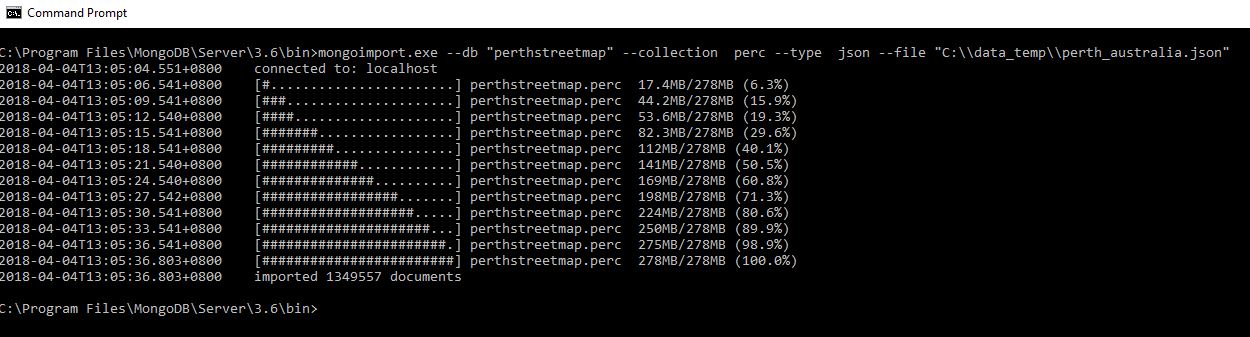


## Exploring loaded data


In [1]:
import pymongo
conn = pymongo.MongoClient()
db = conn.perthstreetmap #perthstreetmap is my database
perth_db = db.perc #Here perc is my collection

#JUST check one document
array = list(perth_db.find({"id":"21390191"}))

print (array)



[{'_id': ObjectId('5ac45d00e17701ecb30a33c0'), 'type': 'node', 'id': '21390191', 'pos': [-31.9539488, 115.897975], 'created': {'version': '3', 'timestamp': '2012-07-30T06:43:33Z', 'changeset': '12543711', 'uid': '189263', 'user': 'wildmyron'}}]


Calculating the  number of created documents, this number is the same as in MongoDB Compass Comunity utility to visualize database  1349557

In [2]:
docnum = db.perc.count()  
print ("Num of docs:", docnum)

Num of docs: 1349557


In [3]:
perth_db.find_one()

{'_id': ObjectId('5ac45d00e17701ecb30a33bd'),
 'created': {'changeset': '49785638',
  'timestamp': '2017-06-24T03:12:01Z',
  'uid': '943785',
  'user': 'sb9576',
  'version': '4'},
 'id': '21390184',
 'pos': [-31.9566674, 115.9019951],
 'type': 'node'}

Now, I will calculate the number of nodes and ways. I will do this separately for nodes and ways with the help of aggregation. 

In [4]:
# How many nodes and ways?
result1=list(db.perc.aggregate([{ "$group" : { "_id" : "$type",
                                               "count" : { "$sum" : 1 } } },
                                #print in ascending order
                                { "$sort" : { "count" : -1 } } ] ) )
print(result1)

[{'_id': 'node', 'count': 1203891}, {'_id': 'way', 'count': 145666}]


Ok, there are 1203891 unique nodes and  145666 ways.
Let's count number of users and which user contributed most.


In [5]:
#total number of records of number of documents could be calculated this way as well
result2=list(db.perc.aggregate([{ "$group" : { "_id" : "$uid",
                                               "count" : { "$sum" : 1 } } },
                                { "$sort" : { "count" : -1 } } ] ) )
print(result2)

[{'_id': None, 'count': 1349557}]


In [6]:
# Top 5 users contributor by number of contributions?

result4 = list(db.perc.aggregate([{ "$group" : { "_id" : "$created.user",
                                               "count" : { "$sum" : 1 } } },
                                  #sort in descending order
                                { "$sort" : { "count" : -1 } },
                                  #print only first one on the top
                                { "$limit" : 5 } ] ))

print(result4)

[{'_id': 'SDavies', 'count': 353260}, {'_id': 'aaronsta', 'count': 158249}, {'_id': 'browny_au', 'count': 139725}, {'_id': 'sb9576', 'count': 106248}, {'_id': 'Andrew Gregory', 'count': 58485}]


Total number of users is 1349557, and top 5 contributors and total number of their notes in Perth map are:

'SDavies', 'count': 353260
'aaronsta', 'count': 158249
'browny_au', 'count': 139725
'sb9576', 'count': 106248
'Andrew Gregory', 'count': 58485

Count number of unique users

{'_id': ObjectId('5ac45d00e17701ecb30a33bd'),
 'created': {'changeset': '49785638',
  'timestamp': '2017-06-24T03:12:01Z',
  'uid': '943785',
  'user': 'sb9576',
  'version': '4'},
 'id': '21390184',
 'pos': [-31.9566674, 115.9019951],
 'type': 'node'}
 

In [7]:
# count a number of unique users
result4 = list(perth_db.aggregate([{ "$group" : { "_id" : "$created.user","count" : { "$sum" : 1 } } },
                                  {"$group": {"_id": "unique_users", "count": { "$sum" : 1 } } },
                                 ] ))

print(result4)

[{'_id': 'unique_users', 'count': 1236}]


Ok, 1236 of unique users contributed to Perth map. 
Let's see the top 20 list of amenities in Perth:

In [8]:
#top 20 of amenities

result = list(perth_db.aggregate( [ { "$match" : { "amenity" : { "$exists" : 1 } } },
                                  { "$group" : { "_id" : "$amenity",
                                                 "count" : { "$sum" : 1 } } },
                                  { "$sort" : { "count" : -1} },
                                  { "$limit" : 20 } ] ))
print(result)


[{'_id': 'parking', 'count': 2557}, {'_id': 'school', 'count': 511}, {'_id': 'restaurant', 'count': 415}, {'_id': 'fast_food', 'count': 384}, {'_id': 'cafe', 'count': 376}, {'_id': 'bench', 'count': 357}, {'_id': 'drinking_water', 'count': 272}, {'_id': 'toilets', 'count': 264}, {'_id': 'post_box', 'count': 243}, {'_id': 'place_of_worship', 'count': 228}, {'_id': 'telephone', 'count': 177}, {'_id': 'fuel', 'count': 175}, {'_id': 'bicycle_parking', 'count': 161}, {'_id': 'shelter', 'count': 159}, {'_id': 'pub', 'count': 132}, {'_id': 'atm', 'count': 111}, {'_id': 'bbq', 'count': 111}, {'_id': 'pharmacy', 'count': 97}, {'_id': 'waste_basket', 'count': 93}, {'_id': 'bank', 'count': 81}]


So, the list is of top 10 amenities:
'parking', 'count': 2557
'school', 'count': 511 
'restaurant', 'count': 415
'fast_food', 'count': 384
'cafe', 'count': 376
'bench', 'count': 357 
'drinking_water', 'count': 272
'toilets', 'count': 264
'post_box', 'count': 243 
'place_of_worship', 'count': 228



Find streets with most of eating places


In [9]:
result=list(perth_db.aggregate([{"$match": {'$or':[
                {"amenity": "restaurant"},
                {"amenity": "fast_food"} ,
                {"amenity": "pub"} ,
                {"amenity": "cafe"} ] },
                  } ,
    {'$group': {"_id": "$address.street", "count": {"$sum": 1} } },
    {'$sort': { "count": -1 } },
    {'$limit': 5} ]))
result


[{'_id': None, 'count': 1307}]

OK, lets see where it the highest place in Perth

In [14]:
#SORTING NEEDS TO BE FIXED, DOESNT SHOW THE RIGHT ORDER OF ELEVATION OF PEAKS
#list top-10 peaks in perth and sorts them by elevation
result = list(perth_db.aggregate( [ { "$match" : { "natural" : "peak" } },
                                  { "$project" : { "_id" : 0,
                                                   "Peak" : "$name",
                                                   "elevation" : "$ele"  } }  ,
                                  { "$sort" : { "elevation" : -1 } },
                                  {"$limit": 40}
                                  ] ))
print(result)

[{'Peak': 'Reabold Hill', 'elevation': '85'}, {'Peak': 'Tamworth hill', 'elevation': '76'}, {'Peak': 'Mount Moke', 'elevation': '55'}, {'Peak': 'Stake Hill', 'elevation': '48'}, {'elevation': '45'}, {'Peak': 'Mount Curtis', 'elevation': '413'}, {'Peak': 'Mount Gunjin', 'elevation': '398'}, {'Peak': 'Clontarf Hill', 'elevation': '33'}, {'Peak': 'Mount Mambup', 'elevation': '224'}, {'Peak': 'Mount Henry'}, {'Peak': 'Wadjemup Hill'}, {'Peak': 'Lookout Hill'}, {'Peak': 'White Hill'}, {'Peak': 'Bare Hill'}, {'Peak': 'Armstrong Hill'}, {'Peak': 'Mount Flora'}, {'Peak': 'Cantonment Hill'}, {'Peak': 'Mount Brown'}, {}, {}, {'Peak': 'Banksia Hill'}, {'Peak': 'Dog Hill'}, {'Peak': 'Gidgegannup Hill'}, {'Peak': 'Mount Klein'}, {'Peak': 'Mount Lotus'}, {'Peak': 'Mount Stewart'}, {'Peak': 'Myara Hill'}, {'Peak': 'Pine Hill'}, {'Peak': 'Red Hill'}, {'Peak': 'South Hill'}, {'Peak': 'Mount Oakover'}, {'Peak': 'Bonorin Hill'}, {'Peak': 'Mount Yokine'}, {'Peak': 'Woodsome Hill'}, {'Peak': 'Peelhurst Hil

In [11]:
#JUST check one document  'Peak': 'Mount Curtis', 'elevation': '413'
array = list(perth_db.find({"ele":"413"}))

print (array)

[{'_id': ObjectId('5ac45d15e17701ecb318adbd'), 'type': 'node', 'id': '3020140915', 'pos': [-32.21201, 116.11379], 'created': {'version': '1', 'timestamp': '2014-08-16T12:04:13Z', 'changeset': '24785572', 'uid': '1187510', 'user': 'dhx1'}, 'ele': '413', 'name': 'Mount Curtis', 'natural': 'peak'}]


In [13]:
# How many peaks are there in the dataset?
num_peaks=perth_db.find({"natural" : "peak"}).count()
print(num_peaks)


38


In [16]:
#  Count everything that is listed at natural per categorie

result = list(perth_db.aggregate( [ { "$match" : { "natural" : { "$exists" : 1 } } },
                                  { "$group" : { "_id" : "$natural",
                                                 "count" : { "$sum" : 1 } } },
                                  { "$sort" : { "count" : -1 } } ] ))
print(result)

[{'_id': 'wood', 'count': 3799}, {'_id': 'tree', 'count': 3177}, {'_id': 'scrub', 'count': 1455}, {'_id': 'water', 'count': 1092}, {'_id': 'bare_rock', 'count': 817}, {'_id': 'wetland', 'count': 129}, {'_id': 'beach', 'count': 104}, {'_id': 'grassland', 'count': 79}, {'_id': 'tree_row', 'count': 64}, {'_id': 'bay', 'count': 55}, {'_id': 'sand', 'count': 51}, {'_id': 'coastline', 'count': 48}, {'_id': 'peak', 'count': 38}, {'_id': 'cliff', 'count': 34}, {'_id': 'cape', 'count': 27}, {'_id': 'heath', 'count': 17}, {'_id': 'rock', 'count': 12}, {'_id': 'waterway', 'count': 6}, {'_id': 'islet', 'count': 3}, {'_id': 'cave_entrance', 'count': 2}, {'_id': 'reef', 'count': 2}, {'_id': 'or', 'count': 1}, {'_id': 'valley', 'count': 1}, {'_id': 'grass', 'count': 1}, {'_id': 'dunes', 'count': 1}, {'_id': 'scree', 'count': 1}, {'_id': 'spring', 'count': 1}]


In [21]:
result = list(perth_db.aggregate( [ { "$match" : { "natural" : "beach" } },
                                  { "$project" : { "_id" : 0,
                                                   "beach" : "$name"
                                                     } }  ,
                                  { "$sort" : { "beach" : -1 } },
                                  {"$limit": 40}
                                  ] ))
print(result)

[{'beach': 'Waterman Beach'}, {'beach': 'Warnbro Beach'}, {'beach': 'Trigg Beach'}, {'beach': 'Spider Beach'}, {'beach': 'Spider Beach'}, {'beach': 'South Trigg Beach'}, {'beach': 'South Beach'}, {'beach': 'South Beach'}, {'beach': 'Singleton Beach'}, {'beach': 'Shelley Beach'}, {'beach': 'Secret Harbour Beach'}, {'beach': 'Scarborough Beach'}, {'beach': 'Port Beach'}, {'beach': 'Pinkie Beach'}, {'beach': 'Peters Pool'}, {'beach': 'North Cottesloe Beach'}, {'beach': 'North Beach'}, {'beach': 'Mosman Beach'}, {'beach': 'Mettams Pool'}, {'beach': 'Madora Beach'}, {'beach': 'Leighton Beach'}, {'beach': 'Golden Bay Beach'}, {'beach': 'Cottesloe Beach'}, {'beach': 'City Beach'}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


In [25]:
# Count all places of worship
result = list(perth_db.aggregate( [ { "$match" : { "amenity" : { "$exists" : 1 },
                                                 "amenity" : "place_of_worship" } },
                                  { "$group" : { "_id" : "$religion",
                                                 "count" : { "$sum" : 1 } } },
                                  { "$sort" : { "count" : -1} },
                                  { "$limit" : 5 } ] ))
print(result)

[{'_id': 'christian', 'count': 188}, {'_id': None, 'count': 27}, {'_id': 'muslim', 'count': 4}, {'_id': 'buddhist', 'count': 4}, {'_id': 'jewish', 'count': 2}]


In [34]:
#where are jewish places of worship
array = list(perth_db.find({"religion":"jewish"}))

print (array)

[{'_id': ObjectId('5ac45d1de17701ecb31d98bb'), 'type': 'way', 'id': '146536967', 'created': {'version': '3', 'timestamp': '2015-09-18T01:43:36Z', 'changeset': '34094835', 'uid': '506275', 'user': 'Bkissin'}, 'address': {}, 'name': 'Temple David', 'phone': '+61 8 9271 1485', 'amenity': 'place_of_worship', 'website': 'http://www.templedavid.org.au/', 'religion': 'jewish', 'node_refs': ['1598210173', '1598210176', '1598210177', '1598210184', '1598210187', '1598210182', '1598210178', '1598210174', '1598210173']}, {'_id': ObjectId('5ac45d1fe17701ecb31e4abf'), 'type': 'way', 'id': '253996730', 'created': {'version': '1', 'timestamp': '2013-12-28T14:49:07Z', 'changeset': '19679701', 'uid': '663232', 'user': 'OSMNZ'}, 'amenity': 'place_of_worship', 'religion': 'jewish', 'node_refs': ['2598389531', '2598389529', '2598389526', '2598389524', '2598389521', '2598389523', '2598389522', '2598389525', '2598389528', '2598389527', '2598389530', '2598389533', '2598389532', '2598389531']}]


In [27]:
# Find out which one is the most popular cuisine in Perth

result = list(perth_db.aggregate( [ { "$match" : { "amenity" : { "$exists" : 1 }, "amenity":"restaurant"} },
                                  { "$group" : { "_id" : "$cuisine",
                                                 "count" : { "$sum" : 1 } } },
                                  { "$sort" : { "count" : -1} },
                                  { "$limit" : 10 } ] ))
print(result)

[{'_id': None, 'count': 169}, {'_id': 'chinese', 'count': 39}, {'_id': 'italian', 'count': 28}, {'_id': 'indian', 'count': 28}, {'_id': 'thai', 'count': 16}, {'_id': 'pizza', 'count': 15}, {'_id': 'asian', 'count': 12}, {'_id': 'japanese', 'count': 11}, {'_id': 'burger', 'count': 7}, {'_id': 'vietnamese', 'count': 7}]


In [33]:
#where can I find a burger??
array = list(perth_db.find({"cuisine":"burger"}))

print (array)

[{'_id': ObjectId('5ac45d01e17701ecb30aac70'), 'type': 'node', 'id': '200823156', 'pos': [-31.835794, 115.7841563], 'created': {'version': '6', 'timestamp': '2012-07-21T06:03:24Z', 'changeset': '12401203', 'uid': '134344', 'user': 'Andrew Gregory'}, 'name': 'Hungry Jacks', 'amenity': 'fast_food', 'cuisine': 'burger'}, {'_id': ObjectId('5ac45d01e17701ecb30abeb9'), 'type': 'node', 'id': '243703192', 'pos': [-32.0389257, 115.9084703], 'created': {'version': '5', 'timestamp': '2017-09-13T11:01:04Z', 'changeset': '52002535', 'uid': '339581', 'user': 'nyuriks'}, 'address': {}, 'amenity': 'fast_food', 'cuisine': 'burger', 'name': "McDonald's", 'opening_hours': '24/7', 'phone': '+61 8 9354 8279', 'website': 'http://mcdonalds.com.au/'}, {'_id': ObjectId('5ac45d01e17701ecb30ae6ca'), 'type': 'node', 'id': '267608539', 'pos': [-31.9939453, 115.9120926], 'created': {'version': '3', 'timestamp': '2010-08-06T16:49:32Z', 'changeset': '5418228', 'uid': '207745', 'user': 'NE2'}, 'name': "McDonald's", 'a